In [1]:
import sys
sys.path.append("..")

In [250]:
"""Train CIFAR10 with PyTorch.
mostly from  https://github.com/zhirongw/lemniscate.pytorch/blob/master/cifar.py, AET
"""
from __future__ import print_function

import os
import argparse
import time
import logging

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torchvision.transforms as tfs
from tensorboardX import SummaryWriter
from matplotlib import pyplot as plt

from src.asano import models
from src.asano.util import AverageMeter
from src.asano.cifar_utils import kNN, CIFAR10Instance, CIFAR100Instance
from src.ml.sinkhorn import SinkhornValue, pot_sinkhorn
from src.utils import accuracy


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s]: %(message)s"
)

In [3]:
def feature_return_switch(model, bool=True):
    """
    switch between network output or conv5features
        if True: changes switch s.t. forward pass returns post-conv5 features
        if False: changes switch s.t. forward will give full network output
    """
    if bool:
        model.headcount = 1
    else:
        model.headcount = args.hc
    model.return_features = bool

In [4]:
parser = argparse.ArgumentParser(
    description="PyTorch Implementation of Self-Label for CIFAR10/100")

parser.add_argument("--device", default="1", type=str,
                    help="cuda device")
parser.add_argument("--resume", "-r", default="", type=str,
                    help="resume from checkpoint")
parser.add_argument("--test-only", action="store_true",
                    help="test only")
parser.add_argument("--restart", action="store_true",
                    help="restart opt")

# model
parser.add_argument("--arch", default="alexnet", type=str,
                    help="architecture")
parser.add_argument("--ncl", default=512, type=int,
                    help="number of clusters")
parser.add_argument("--hc", default=1, type=int,
                    help="number of heads")

# SK-optimization
parser.add_argument("--lamb", default=10.0, type=float,
                    help="SK lambda parameter")
parser.add_argument("--nopts", default=400, type=int,
                    help="number of SK opts")

# Queue
parser.add_argument("--max_queue_len", default=0, type=int,
                    help="Maximum number of batches in queue")
parser.add_argument("--queue_start_epoch", default=10, type=int,
                    help="Queue will start at this epoch, if enabled")

# optimization
parser.add_argument("--lr", default=0.001, type=float,
                    help="learning rate")
parser.add_argument("--momentum", default=0.9, type=float,
                    help="sgd momentum")
parser.add_argument("--epochs", default=10, type=int,
                    help="number of epochs to train")
parser.add_argument("--batch-size", default=256, type=int, metavar="BS",
                    help="batch size")
parser.add_argument("--wd", default=1e-6, type=float,
                    help="weight decay")

# logging saving etc.
parser.add_argument("--save_model", action="store_true",
                    help="Save model during training")
parser.add_argument("--datadir", default="../data", type=str,
                    help="datadir")
parser.add_argument("--exp", default="../expe", type=str,
                    help="experimentdir")
parser.add_argument("--type", default="10", type=int,
                    help="cifar10 or 100")

args = parser.parse_args(args=[])

In [5]:
# setup_runtime(2, [args.device])
device = "cuda" if torch.cuda.is_available() else "cpu"
knn_dim = 4096
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [192]:
# Data
logging.info("==> Preparing data..")
transform_train = tfs.Compose([
    tfs.Resize(256),
    tfs.RandomResizedCrop(size=224, scale=(0.2, 1.)),
    tfs.ColorJitter(0.4, 0.4, 0.4, 0.4),
    tfs.RandomGrayscale(p=0.2),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = tfs.Compose([
    tfs.Resize(256),
    tfs.CenterCrop(224),
    tfs.ToTensor(),
    tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

if args.type == 10:
    cifar_instance = CIFAR10Instance
else:
    cifar_instance = CIFAR100Instance

trainset = cifar_instance(
    root=args.datadir,
    train=True,
    download=True,
    transform=transform_train
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=8,
    drop_last=True
)

testset = cifar_instance(
    root=args.datadir,
    train=False,
    download=True,
    transform=transform_test
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=512,
    shuffle=False,
    num_workers=2
)

2022-01-31 10:12:46,451 [INFO]: ==> Preparing data..


Files already downloaded and verified
Files already downloaded and verified


In [183]:
logging.info("==> Building model..")

numc = [args.ncl] * args.hc
model = models.__dict__[args.arch](num_classes=numc)
knn_dim = 4096

N = len(trainloader.dataset)

optimizer = optim.SGD(
    model.parameters(),
    lr=args.lr,
    momentum=args.momentum,
    weight_decay=args.wd
)

model.to(device)

name = "%s" % args.exp.replace("/", "_")
writer = SummaryWriter(f"./runs/cifar{args.type}/{name}")
writer.add_text("args", " \n".join(
    ["%s %s" % (arg, getattr(args, arg)) for arg in vars(args)]))

logging.info(name)

2022-01-31 10:11:52,129 [INFO]: ==> Building model..
2022-01-31 10:11:53,231 [INFO]: ._expe


# Train

In [213]:
# Training
def train(epoch, SV):
    logging.info("Epoch: {0}".format(epoch))

    # adjust_learning_rate(optimizer, epoch)
    train_loss = AverageMeter()
    data_time = AverageMeter()
    batch_time = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    for batch_idx, (inputs, targets, indexes) in enumerate(trainloader):
        data_time.update(time.time() - end)

        # Prepare input data
        inputs, targets, indexes = (
            inputs.to(device),
            targets.to(device),
            indexes.to(device)
        )

        # Forward model
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute loss
        if args.hc == 1:  # single classification head
            loss = SV(-outputs)
        else:             # multi classification head
            loss = torch.mean(
                torch.stack(
                    [SV(-outputs[h]) for h in range(args.hc)]
                )
            )

        # Queue section
        if (SV.max_n_batches_in_queue > 0) \
                and (epoch >= args.queue_start_epoch):
            # If the queue should be used
            if SV.queue_is_full:
                # If the queue is full
                # Run backward
                loss.backward()
                optimizer.step()
                # And update with current batch
                SV.update_queue(-outputs)
            else:
                # Otherwise, don't run backward and simply update
                logging.warning("Queue is not full yet, skipping batch {0}"
                                .format(batch_idx))
                SV.update_queue(-outputs)
                continue
        else:
            # Do not use the queue, run backward normally
            loss.backward()
            optimizer.step()

        logging.debug(
            "Batch {0} (Size={1}): Loss={2:.5f}".format(
                batch_idx,
                inputs.shape[0],
                loss.item()
            )
        )

        train_loss.update(loss.item(), inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 20 == 0:
            logging.info(
                "Epoch: [{}][{}/{}]"
                "Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Data: {data_time.val:.3f} ({data_time.avg:.3f}) "
                "Loss: {train_loss.val:.4f} ({train_loss.avg:.4f})"
                .format(
                    epoch,
                    batch_idx,
                    len(trainloader),
                    batch_time=batch_time,
                    data_time=data_time,
                    train_loss=train_loss
                )
            )
            writer.add_scalar(
                "loss",
                loss.item(),
                batch_idx * 512 + epoch*len(trainloader.dataset)
            )

In [214]:
SV = SinkhornValue(
    epsilon=1./args.lamb,
    solver=pot_sinkhorn,
    max_n_batches_in_queue=args.max_queue_len,
    stopThr=1e-02,
    method="sinkhorn_log",
    numItermax=args.nopts
)

logging.info(SV)

2022-01-31 10:19:25,311 [INFO]: SinkhornValue(epsilon=1.00e-01, solver=<function pot_sinkhorn at 0x7fd3dc218d30>,solver_options={'stopThr': 0.01, 'method': 'sinkhorn_log', 'numItermax': 400})


In [215]:
# Compute accuracy before training the model
feature_return_switch(model, True)
acc = kNN(model, trainloader, testloader, K=10, sigma=0.1, dim=knn_dim)
feature_return_switch(model, False)

2022-01-31 10:21:34,060 [INFO]: 10-NN, s=0.1: TOP1:50.5


In [216]:
# Training epochs
for epoch in range(start_epoch, start_epoch + args.epochs):
    train(epoch, SV)
    # feature_return_switch(model, True)
    # acc = kNN(model, trainloader, testloader, K=10, sigma=0.1, dim=knn_dim)
    # feature_return_switch(model, False)
    # writer.add_scalar("accuracy_kNN", acc, epoch)

2022-01-31 10:21:34,120 [INFO]: Epoch: 0
2022-01-31 10:21:37,041 [INFO]: Epoch: [0][0/195]Time: 2.917 (2.917) Data: 2.756 (2.756) Loss: 5.4777 (5.4777)
2022-01-31 10:21:39,231 [INFO]: Epoch: [0][10/195]Time: 0.164 (0.464) Data: 0.018 (0.318) Loss: 5.4205 (5.4465)
2022-01-31 10:21:41,476 [INFO]: Epoch: [0][20/195]Time: 0.163 (0.350) Data: 0.019 (0.205) Loss: 5.3536 (5.4202)
2022-01-31 10:21:43,690 [INFO]: Epoch: [0][30/195]Time: 0.167 (0.309) Data: 0.021 (0.164) Loss: 5.2928 (5.3897)
2022-01-31 10:21:46,096 [INFO]: Epoch: [0][40/195]Time: 0.366 (0.292) Data: 0.218 (0.147) Loss: 5.2321 (5.3573)
2022-01-31 10:21:48,614 [INFO]: Epoch: [0][50/195]Time: 0.170 (0.284) Data: 0.027 (0.139) Loss: 5.1587 (5.3232)
2022-01-31 10:21:50,828 [INFO]: Epoch: [0][60/195]Time: 0.168 (0.274) Data: 0.025 (0.129) Loss: 5.0808 (5.2881)
2022-01-31 10:21:53,021 [INFO]: Epoch: [0][70/195]Time: 0.162 (0.266) Data: 0.020 (0.121) Loss: 4.9868 (5.2513)
2022-01-31 10:21:55,279 [INFO]: Epoch: [0][80/195]Time: 0.175 (0

# Cluster interpretation

In [239]:
imgs = []
labels = []

In [240]:
# Loop over all test batches and predict labels
feature_return_switch(model, False)  # model should not return features but softmax instead

for (inputs, targets, indexes) in testloader:
    outputs = model(inputs.to(device))   # softmax labels
    assigned_labels = torch.argmax(outputs[0], axis=1)  # use only first classification head for now
    
    imgs.append(inputs)
    labels.append(assigned_labels)

In [244]:
imgs = torch.cat(imgs)
labels = torch.cat(labels)

In [256]:
# Top 5 largest clusters
pd.Series(labels.cpu().data.numpy()).value_counts().head(5)

138    54
112    49
98     49
379    48
441    47
dtype: int64

In [259]:
# Inverse transform images
invTrans = tfs.Compose(
    [
        tfs.Normalize(mean = [ 0., 0., 0. ],
                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                      std = [ 1., 1., 1. ]),
    ]
)

2022-01-31 10:45:16,961 [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-01-31 10:45:16,964 [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-01-31 10:45:16,967 [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-01-31 10:45:16,969 [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-01-31 10:45:16,972 [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-01-31 10:45:16,974 [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-01-31 10:45:16,977 [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] 

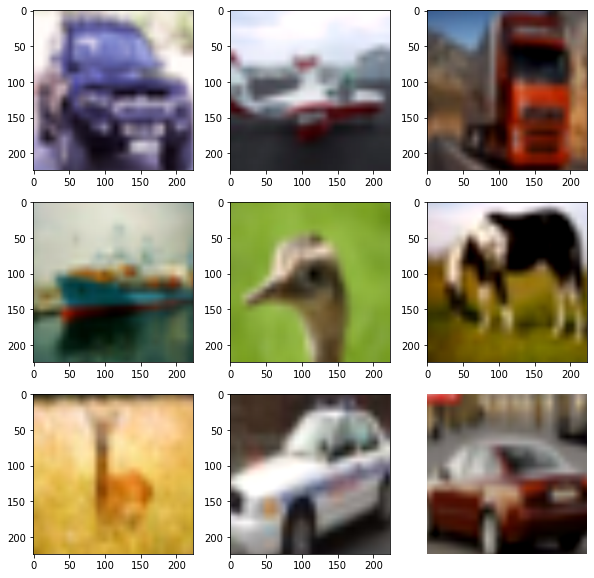

In [260]:
# Plot 9 images from a single cluster
same_labels_imgs = torch.where(labels == 138)[0][:9]  # pick cluster here (e.g. 138)

inputs_inv = invTrans(imgs[same_labels_imgs])

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(inputs_inv.shape[0]):
    row_ix = i // 3
    col_ix = i % 3
    
    axs[row_ix][col_ix].imshow(inputs_inv[i].permute(1, 2, 0))
    axs[row_ix][col_ix].axis("off")
    
plt.show()

# Eval

In [274]:
class RegLog(nn.Module):
    """Creates logistic regression on top of frozen features"""

    def __init__(self, num_labels):
        super(RegLog, self).__init__()
        s = 4096
        
        self.linear = nn.Linear(s, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # linear layer
        return self.linear(x)

In [275]:
# training statistics
top1 = AverageMeter()
losses = AverageMeter()

linear_classifier = RegLog(10).to(device)
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=0.01,
)

model.eval()
linear_classifier.train()

for epoch in range(5):
    for batch_idx, (inputs, targets, indexes) in enumerate(testloader):
        optimizer.zero_grad()

        # Prepare input data
        inputs, targets, indexes = (
            inputs.to(device),
            targets.to(device),
            indexes.to(device)
        )

        # Compute NN features
        feature_return_switch(model, True)
        model_out = model(inputs)

        # train classifier
        classifier_out = linear_classifier(model_out)

        # compute cross entropy loss
        loss = criterion(classifier_out, targets)
        losses.update(loss.item(), inputs.size(0))
        loss.backward()
        optimizer.step()

        # compute accuracy
        acc1 = accuracy(classifier_out, targets)
        top1.update(acc1[0], inputs.size(0))

In [276]:
top1.avg, losses.avg

(tensor([10.0060], device='cuda:0'), 457.22269869628906)